In [2]:
#Расчёт пластинчатого ТО (волны-sandia)
import matplotlib.pyplot as pt
import numpy as n
from CoolProp.CoolProp import PropsSI as p
from scipy.optimize import root
import math as m

#Исходные данные:
G1 = 758 #горяч
T11 = 81.77
T12 = 43.54

G2 = 758
T21 = 38.54



P11=5300000
P21=18000000
P12 = P11
P22 = P21

##############################################
CO2  = 'REFPROP::CO2'
H2O  = 'REFPROP::WATER'
O2   = 'REFPROP::Oxygen'
MIX1 =  'REFPROP::CO2[0.931]&WATER[0.069]'
MIX2 =  'REFPROP::CO2[0.993]&WATER[0.007]'
MIX05 =  'REFPROP::CO2[0.95]&WATER[0.05]' #Для транспортный свойств


H11  = p('H','T', T11+273.15, 'P', P11, CO2) #заменить на СО2
H12  = p('H','T', T12+273.15, 'P', P11, CO2)
H21  = p('H','T', T21+273.15, 'P', P21, CO2)

#Разбиение по энтальпии:
s    = 100 #Кол-во шагов
step = (H11-H12)/(s) 

#Нулевые массивы:
t1   = n.zeros(s+1)
t2   = n.zeros(s+1)
Q    = n.zeros(s+1)

#Противоток:
h11 = H11
i=0
for i in range(s+1):
    t1[i] = p('T','H', h11, 'P', P11, CO2)-273.15 
    h12 = h11 - step
    dQ = G1 * (h11-h12)
    if i < s:
        Q[i+1]=Q[i]+dQ
    h11 = h12
h21 = H21
i=0
for i in range(s+1):
    t2[s-i] = p('T','H', h21, 'P', P21, CO2)-273.15  
    h22 = h21+((Q[s-i]-Q[s-i-1])/G2)
    h21 = h22
DT=t1-t2
##############################################
print(min(DT))

t1av = n.zeros(s)
t2av = n.zeros(s)
ro1 = n.zeros(s)
ro2 = n.zeros(s)
nu1 = n.zeros(s)
nu2 = n.zeros(s)
lambda1 = n.zeros(s)
lambda2 = n.zeros(s)
Pr1 = n.zeros(s)
Pr2 = n.zeros(s)
DTav = n.zeros(s)
w1 = n.zeros(s)
w2= n.zeros(s)
Re1= n.zeros(s)
Re2= n.zeros(s)
Nu1= n.zeros(s)
Nu2= n.zeros(s)
f1= n.zeros(s)
f2= n.zeros(s)
alpha1= n.zeros(s)
alpha2= n.zeros(s)
K= n.zeros(s)
F= n.zeros(s+1)
L= n.zeros(s+1)
P1= n.zeros(s+1)
P2= n.zeros(s+1)


ddP1     =n.zeros(10000)
ddP2     =n.zeros(10000)
ddP4     =n.zeros(10000)
ddP6     =n.zeros(10000)
ddP8     =n.zeros(10000)
ddP10    =n.zeros(10000)




Vv     =n.zeros(10000000)
DdP1   =n.zeros(10000000)
DdP2   =n.zeros(10000000)
Ff     =n.zeros(10000000)
Ll     =n.zeros(10000000)
Nnsumm =n.zeros(10000000)

#Для каждого участка:
for i in range(s):
    #Свойства
    t1av[i]   =(t1[i]+t1[i+1])/2
    t2av[i]   =(t2[i]+t2[i+1])/2
    ro1[i]    =p('D','T', t1av[i]+273.15, 'P', P11, CO2)
    ro2[i]    =p('D','T', t2av[i]+273.15, 'P', P21, CO2)
    nu1[i]    =p('V','T', t1av[i]+273.15, 'P', P11, CO2)/ro1[i]
    nu2[i]    =p('V','T', t2av[i]+273.15, 'P', P21, CO2)/ro2[i]
    lambda1[i]=p('L','T', t1av[i]+273.15, 'P', P11, CO2)
    lambda2[i]=p('L','T', t2av[i]+273.15, 'P', P21, CO2)
    Pr1[i]    =p('PRANDTL','T', t1av[i]+273.15, 'P', P11, CO2)
    Pr2[i]    =p('PRANDTL','T', t2av[i]+273.15, 'P', P21, CO2)
    DTav[i]   =t1av[i]-t2av[i]
#От выпадающих Pr:
for i in range(1,s):
    if abs(Pr1[i]-Pr1[i-1])>Pr1[i-1]:
        Pr1[i]=p('PRANDTL','T', t1[i]+273.15, 'P', P11, CO2)
    if abs(Pr2[i]-Pr2[i-1])>Pr2[i-1]:
        Pr2[i]=p('PRANDTL','T', t2[i]+273.15, 'P', P21, CO2)

#Геометрия
delta = 0.002       #толщина металла
hc = 0.00094        #высота канала
wpl = 1             #ширина пластины
wc = wpl/1.254      #ширина проходного сечения
fprohc = wc*hc      #проходное сечение 1 пластины
dh =0.00109         #характерный размер
hpl = hc+delta      #высота пластины
lambdaw = 20        #теплопроводность металла

#Геометрия "выхода":
roout1 = p('D','T', t1[s]+273.15, 'P', P11, CO2)
roout2 = p('D','T', t2[s]+273.15, 'P', P21, CO2)


print('+')
j=0


wout1= 20 #заменить


Fproh1 = G1/(roout1*wout1)
Npl1 = m.ceil(Fproh1/fprohc)
Npl2 = m.ceil(Npl1/2)
Nsumm = Npl1+Npl2
Fproh2 = Npl2*fprohc
Fl = ((Npl1+Npl2)/2)*(1.905)


P1[0]=P11
P2[0]=P21
#Для каждого участка:
for i in range(s):
    w1[i] = G1/(ro1[i]*Fproh1)
    w2[i] = G2/(ro2[i]*Fproh2)
    Re1[i]=w1[i]*dh/nu1[i]
    Re2[i]=w2[i]*dh/nu2[i]
    Nu1[i] = 0.1740*Re1[i]**0.593*Pr1[i]**0.430  #заменить
    Nu2[i] = 0.1740*Re2[i]**0.593*Pr2[i]**0.430
    f1[i] = 0.4545*Re1[i]**-0.340
    f2[i]= 0.4545*Re2[i]**-0.340
    alpha1[i] = Nu1[i]*lambda1[i]/dh
    alpha2[i] = Nu2[i]*lambda2[i]/dh
    
    print(alpha1[i],alpha2[i])
    K[i] = 1/((1/alpha1[i])+(delta/lambdaw)+(1/alpha2[i]))
    dF = (Q[i+1]-Q[i])/(K[i]*DTav[i])
    dL = dF/Fl
    if i < s:
        F[i+1]=F[i]+dF
    if i < s:
        L[i+1]=L[i]+dL
    dP1 = f1[i]*dL/dh*ro1[i]*w1[i]**2/2
    dP2 = f2[i]*dL/dh*ro2[i]*w2[i]**2/2
    if i < s:
        P1[i+1]=P1[i]-dP1
        P2[i+1]=P2[i]-dP2
    DP1 = P1[0]-P1[s]
    DP2 = P2[0]-P2[s]
print("++")
print('Площадь','Высота','Длина','Ширина')
print(F[s], Nsumm*hpl,L[s],wpl)

4.999999994498012
+
4255.114980722624 14327.492432256246
4255.967050491378 14328.681477696042
4256.855718736945 14329.824303708705
4257.7814363124435 14330.922122967677
4258.744660863855 14331.976169876885
4259.7458569671435 14332.987700672245
4260.785496269088 14333.957993252225
4261.864057631817 14334.888346718824
4262.9820272808565 14335.780080942226
4264.139898957228 14336.634535924859
4265.33817407339 14337.45307085934
4266.577361872988 14338.237063214194
4267.857979594748 14338.987907590796
4269.180552640222 14339.707014435813
4270.545614740443 14340.395808724581
4271.953708138986 14341.055728398349
4273.405383781369 14341.688222701718
4274.901201487089 14342.294750527108
4276.4417301345675 14342.87677858233
4278.027547859035 14343.435779494479
4279.659242249592 14343.973229847692
4281.337410550564 14344.490608172031
4283.062659866649 14344.989392820367
4284.835607390824 14345.471059890462
4286.656880513607 14345.937081106653
4288.527117257706 14346.388921617863
4290.44696634746 

Температуры:
600.8062044825352 77.00000282812914
577.3979260075514 60.22751834171851
Тепловая мощность: 411561148.8851412
Длина ТО: 4.611799064016487
Площадь ТО: 22135.00984810907
Минимальный темп. напор: 4.6936423005649885


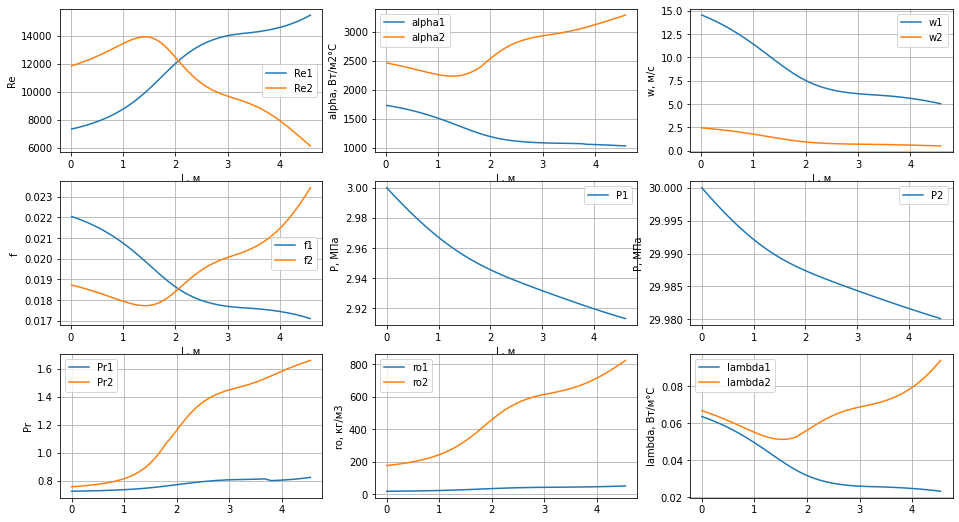

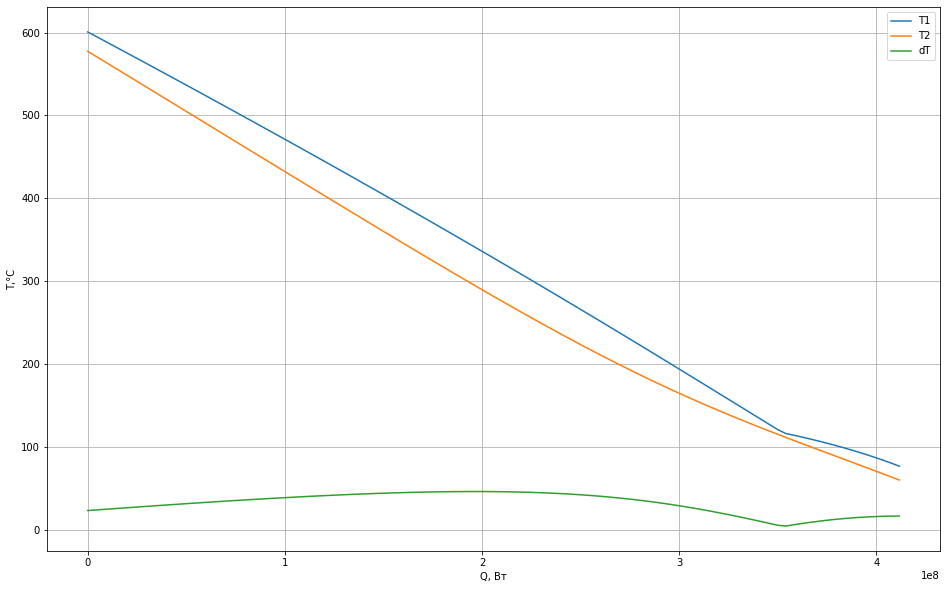

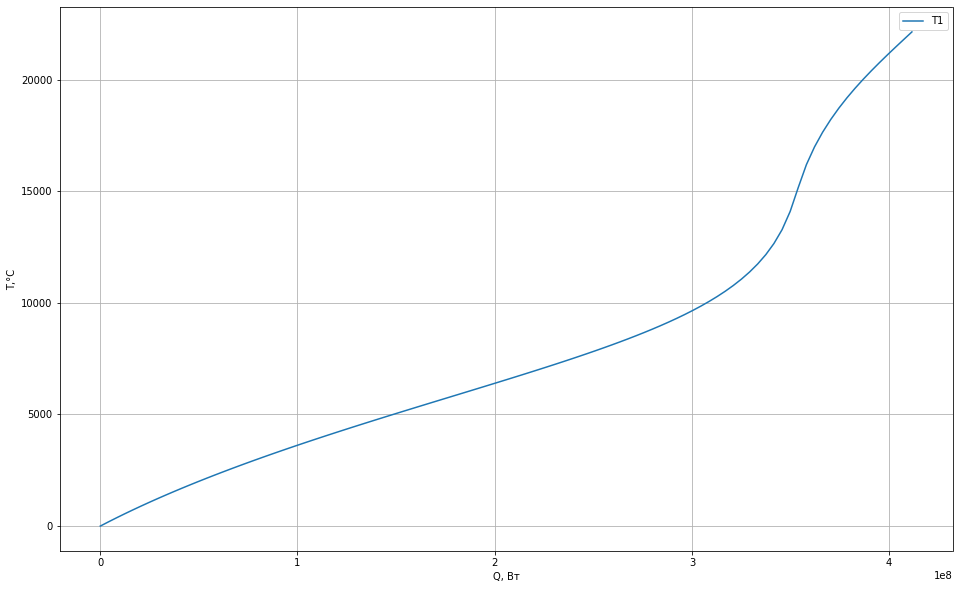

In [3]:
print('Температуры:')
print(t1[0],t1[s])
print(t2[0],t2[s])
print('Тепловая мощность:',Q[s])
print('Длина ТО:',L[s])
print('Площадь ТО:',F[s])
print('Минимальный темп. напор:',min(DT))

pt.figure(figsize=(16, 9))
x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [Re1[i] for i in (range(s))]
y2 = [Re2[i] for i in (range(s))]
pt.subplot(331)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['Re1','Re2'])
pt.xlabel('L, м')
pt.ylabel('Re')

x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [alpha1[i] for i in (range(s))]
y2 = [alpha2[i] for i in (range(s))]
pt.subplot(332)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['alpha1','alpha2'])
pt.xlabel('L, м')
pt.ylabel('alpha, Вт/м2°С')

x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [w1[i] for i in (range(s))]
y2 = [w2[i] for i in (range(s))]
pt.subplot(333)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['w1','w2'])
pt.xlabel('L, м')
pt.ylabel('w, м/с')

x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [f1[i] for i in (range(s))]
y2 = [f2[i] for i in (range(s))]
pt.subplot(334)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['f1','f2'])
pt.xlabel('L, м')
pt.ylabel('f')

x  = [L[i] for i in range(s+1)]  
y1 = [P1[i]/1000000 for i in (range(s+1))]
pt.subplot(335)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['P1'])
pt.xlabel('L, м')
pt.ylabel('P, МПа')

x  = [L[i] for i in range(s+1)]  
y1 = [P2[i]/1000000 for i in (range(s+1))]
pt.subplot(336)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['P2'])
pt.ylabel('P, МПа')

x  = [L[i] for i in range(s)]  
y1 = [Pr1[i] for i in (range(s))]
y2 = [Pr2[i] for i in (range(s))]
pt.subplot(337)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['Pr1','Pr2'])
pt.ylabel('Pr')

x  = [L[i] for i in range(s)]  
y1 = [ro1[i] for i in (range(s))]
y2 = [ro2[i] for i in (range(s))]
pt.subplot(338)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['ro1','ro2'])
pt.ylabel('ro, кг/м3')

x  = [L[i] for i in range(s)]  
y1 = [lambda1[i] for i in (range(s))]
y2 = [lambda2[i] for i in (range(s))]
pt.subplot(339)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['lambda1','lambda2'])
pt.ylabel('lambda, Вт/м°С')
pt.show()


x  = [Q[i] for i in range(s+1)]  
y1 = [t1[i] for i in (range(s+1))]
y2 = [t2[i] for i in (range(s+1))]
y3 = [DT[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x, y2,x,y3)
pt.grid(True)
pt.legend(['T1','T2','dT'])
pt.ylabel('T,°C')
pt.xlabel('Q, Вт')
pt.show()

x  = [Q[i] for i in range(s+1)]  
y1 = [F[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1)
pt.grid(True)
pt.legend(['T1','T2','dT'])
pt.ylabel('T,°C')
pt.xlabel('Q, Вт')
pt.show()

#for i in range(s):
#    print(Q[i],F[i])



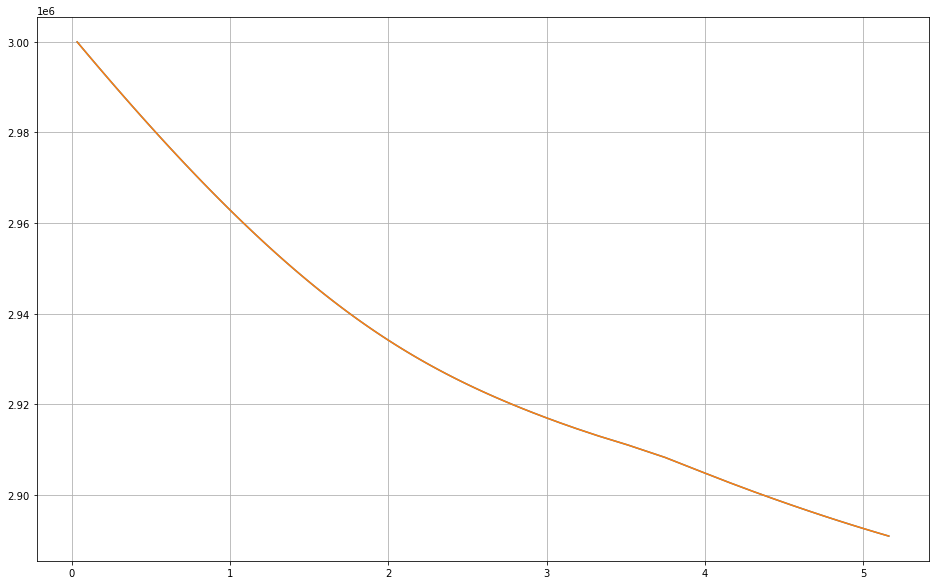

162.60371807011444 0.0681551980292186 0.0711990363308728 15.57983966155621 2.67498719127635
479.50647165573906 0.0677343659777141 0.07078415050257382 15.482218246722976 2.6545486366323607
780.6847696216232 0.06731206967423904 0.07036920085673726 15.384437625017974 2.6340578647939665
1067.776620424327 0.06688829711883366 0.06995423775663015 15.286495425402595 2.613513988591714
1342.1814593698473 0.06646303624009547 0.06953931446933388 15.188389226148196 2.5929161042425304
1605.1045706922341 0.06603627489926944 0.0691244873311315 15.09011655339001 2.5722632912523697
1857.5916380273848 0.06560800089474444 0.06870981592317321 14.991674879627803 2.551554612349559
2100.5559456962906 0.06517820196698641 0.068295363258123 14.893061622170835 2.5307891134531686
2334.800031757063 0.06474686580394133 0.06788119597854152 14.794274141525017 2.5099658236812408
2561.033098990685 0.06431398004694351 0.06746738456781527 14.695309739718782 2.489083755404235
2779.8851447419183 0.06387953229716764 0.067054

In [4]:
x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [P1[i] for i in (range(s))]
y2 = [P1[i] for i in (range(s))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.show()
for i in range(s):
    print((F[i]+F[i+1])/2,lambda1[i],lambda2[i],w1[i],w2[i])